# Deep Neural Network
---

## Setup & Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font="IPAGothic")

import pickle

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

%matplotlib inline
import seaborn as sns
sns.set()

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
#from keras.utils import to_categorical
import torch.nn.functional as F

In [2]:
def visualize_cmx(y_true, y_pred):
    labels=sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cmx, annot=True, annot_kws={"size": 30}, fmt="d", linecolor='yellow', linewidths=5)
    plt.show()
    
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [3]:
def show_values(world, subplot=None, title='Values'):
    if not subplot:
      fig = plt.figure(figsize=(world.size*0.8, world.size*0.8))
      subplot = fig.add_subplot(1, 1, 1)

    result = np.zeros([world.size, world.size])
    for (x, y) in world.states:
      if (x, y) in world.traps:
        result[y][x] = None
      else:
        result[y][x]  = world.value[(x, y)]
    sns.heatmap(result, square=True, cbar=False,
                annot=True, fmt='3.1f', cmap='coolwarm',
                ax=subplot).set_title(title)

## Data

In [4]:
train = pd.read_csv("../data/data.csv", encoding="utf-8")
train.head()

,ID,Target,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing

In [5]:
X = train.drop(["ID", "Target", "Name"], axis=1)
y = train["Target"]

for col in X.columns:
    if X.dtypes[col] == "object":
        X[col] = X[col].fillna("NA")
    else:
        X[col] = X[col].fillna(0)
    X[col] = LabelEncoder().fit_transform(X[col])

In [29]:
# making all variables categorical
for col in X.columns:
    X[col] =X[col].astype('category')

y = LabelEncoder().fit_transform(y)

In [30]:
#categorical embedding for columns having more than two values
embedded_cols = {n: len(col.cat.categories) for n,col in X.items() if len(col.cat.categories) > 2}
embedded_cols

{'Pclass': 3,
 'Age': 89,
 'SibSp': 7,
 'Parch': 7,
 'Ticket': 681,
 'Fare': 248,
 'Cabin': 148,
 'Embarked': 4}

In [31]:
embedded_col_names = embedded_cols.keys()
len(X.columns) - len(embedded_cols) #number of numerical columns

1

In [32]:
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

[(3, 2), (89, 45), (7, 4), (7, 4), (681, 50), (248, 50), (148, 50), (4, 2)]

In [33]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=0)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
569,2,1,43,0,0,415,36,146,3
562,1,1,37,0,0,103,87,146,3
471,2,1,52,0,0,263,54,146,3
825,2,1,0,0,0,448,9,146,2
861,1,1,28,1,0,221,76,146,3


## Dataset

In [11]:
class ShelterOutcomeDataset(Dataset):
    def __init__(self, X, y, embedded_col_names):
        X = X.copy()
        self.X1 = X.loc[:,embedded_col_names].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(list(embedded_col_names), axis=1).copy().values.astype(np.float32)
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
    
def MakeTestDataset(X, y, embedded_col_names):
    X1 = X.loc[:, embedded_col_names].copy().values.astype(np.int64)
    X2 = X.drop(list(embedded_col_names), axis=1).copy().values.astype(np.float32)
    return X1, X2, y

In [12]:
#creating train and valid datasets
train_ds = ShelterOutcomeDataset(X_train, y_train, embedded_col_names)
valid_ds = ShelterOutcomeDataset(X_valid, y_valid, embedded_col_names)
X1_test, X2_test, y_test = MakeTestDataset(X_test, y_test, embedded_col_names)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:

device = get_default_device()

In [41]:
class ShelterOutcomeModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(70)
        self.emb_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)
        

    def forward(self, x_cat, x_cont):
        print("x_cat {}".format(x_cat))
        print("embeddings {}".format(self.embeddings))
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [42]:
print(embedding_sizes)

[(3, 2), (89, 45), (7, 4), (7, 4), (681, 50), (248, 50), (148, 50), (4, 2)]


In [43]:
model = ShelterOutcomeModel(embedding_sizes, 1)
to_device(model, device)

ShelterOutcomeModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(89, 45)
    (2): Embedding(7, 4)
    (3): Embedding(7, 4)
    (4): Embedding(681, 50)
    (5): Embedding(248, 50)
    (6): Embedding(148, 50)
    (7): Embedding(4, 2)
  )
  (lin1): Linear(in_features=208, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=70, bias=True)
  (lin3): Linear(in_features=70, out_features=5, bias=True)
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

In [44]:
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

## Train

In [45]:
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        output = model(x1, x2)
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

def val_loss(model, valid_dl):
    model.eval()
    sum_loss = 0
    total = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1, x2)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    return sum_loss/total

def train_loop(model, epochs, lr=0.01, wd=0.0):
    total_train_loss = []
    total_val_loss = []
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        total_train_loss.append(loss)
        print("training loss: ", loss)
        loss = val_loss(model, valid_dl)
        total_val_loss.append(loss)
    return total_train_loss, total_val_loss

In [46]:
batch_size = 1000
epochs = 1
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)
#test_dl = DataLoader(test_ds, batch_size=1,shuffle=False)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [47]:
total_train_loss, total_val_loss = train_loop(model, epochs=epochs, lr=0.05, wd=0.00001)

x_cat tensor([[  1,  10,   1,  ..., 146, 146,   3],
        [  0,  68,   1,  ..., 227,  37,   3],
        [  2,  22,   0,  ...,  27, 146,   2],
        ...,
        [  2,  25,   1,  ...,  36, 146,   3],
        [  2,  29,   0,  ...,  40, 146,   3],
        [  2,  37,   0,  ...,  40, 146,   3]])
embeddings ModuleList(
  (0): Embedding(3, 2)
  (1): Embedding(89, 45)
  (2): Embedding(7, 4)
  (3): Embedding(7, 4)
  (4): Embedding(681, 50)
  (5): Embedding(248, 50)
  (6): Embedding(148, 50)
  (7): Embedding(4, 2)
)
training loss:  1.809442162513733
x_cat tensor([[  0,  63,   0,   0,   6, 171, 133,   3],
        [  2,  27,   0,   0, 525,  18, 146,   3],
        [  0,   0,   0,   0, 589, 216, 146,   0],
        [  0,  30,   3,   2,  95, 246,  63,   3],
        [  1,   0,   0,   0, 138,   0, 146,   3],
        [  0,  32,   3,   2,  95, 246,  63,   3],
        [  0,  39,   0,   0, 141, 240,  32,   3],
        [  0,  34,   1,   2,  37, 237,  62,   3],
        [  0,   0,   1,   0,  84, 224,  86, 

## Training Curve

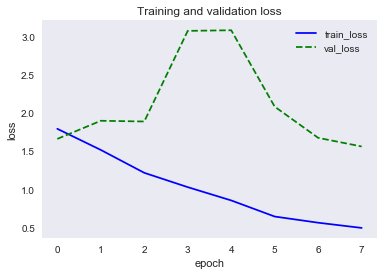

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

plt.plot(range(epochs),  total_train_loss, color='blue', linestyle='-', label='train_loss')
plt.plot(range(epochs), total_val_loss, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

## Predict

In [44]:
y_pred = []

model.eval()

out = model(torch.LongTensor(X1_test), torch.Tensor(X2_test))
prob = F.softmax(out, dim=1)
_, pred = torch.max(prob, 1)
        
y_pred = pred.numpy()

In [45]:
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, y_pred)))
print("Classification_report:\n {}".format(classification_report(y_test, y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("AUC:{}".format(multiclass_roc_auc_score(y_test, y_pred)))

Confusion matrix:
 [[95 15]
 [30 39]]
Classification_report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       110
           1       0.72      0.57      0.63        69

    accuracy                           0.75       179
   macro avg       0.74      0.71      0.72       179
weighted avg       0.75      0.75      0.74       179

Accuracy: 0.7486033519553073
AUC:0.7144268774703557
